# ENSAE - Sampling Methods Project | Experimenting with SVGD using the PyMC package and a comparison with Langevin

<span style="color:yellow">TO DOs: [DELETE THIS PART IN THE END]</span>
- ⁠Check the accuracy as a Sanity check
- ⁠Posterior mean and variance ()
- try out different bandwiths
- ⁠KL divergence between the KDE and the target - posterior mu and sigma
- ⁠more particles / iterations with the SVGD + add plots
- ⁠think about convergence rates for SVGD
- ⁠more priors need to be added
- ⁠Langevin for the Breast cancer dataset
- maybe take the artificial data from the SVGD and use it for the Langevin

## Introduction

We knew that we would like to experiment with SVGD. Following to that, we were thinking of a way how to do that. In the beginning, the following three libaries were up for discussion: PyMC, Stan, BlackJAX. However, it became visible quickly that BlackJAX was little and Stan barely suitable for that. On the other hand, PyMC offers a SVGD class as well as extensive documentation, allowing for rather simple utilization.

The following website contains explanations and tutorials that were helpful to get started with PyMC: https://www.pymc.io/projects/docs/en/latest/learn.html

This notebook contains... <span style="color:yellow">[HERE WE SHOULD ADD A SHORT SUMMARY OF WHAT WE ARE DOING]</span>

### Installation and importing the libraries

To avoid issues with dependencies (that seem to be a thing), we created a new conda environment for this project. It is important to install pymc but also all the other libraries that are imported in the cell down below.

Please have a look at this link (https://www.pymc.io/projects/docs/en/latest/installation.html) to find out how to create and activate a new environment and how to install pymc. After doing so, it was necessary for us to create a new kernel with the ipykernel package (https://ipython.readthedocs.io/en/stable/install/kernel_install.html).

After installing everything, the required packages can be imported:

In [1]:
# import
import pymc as pm
from pymc import model_to_graphviz
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy
import scipy.special
from sklearn.model_selection import train_test_split
from numpy.random import default_rng
from sklearn.preprocessing import MinMaxScaler

## Artificial Data

### Artificial Data - SVGD

Information on SVGD with can be found here: https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.SVGD.html

Before using the breast cancer data set, let's try it out with artificial data.

In the following, the code just generates some artifical linear data and then defines a PyMC model with SVGD to fit the target distribution. In the end, the slope and intercept of 1000 samples is plotted.

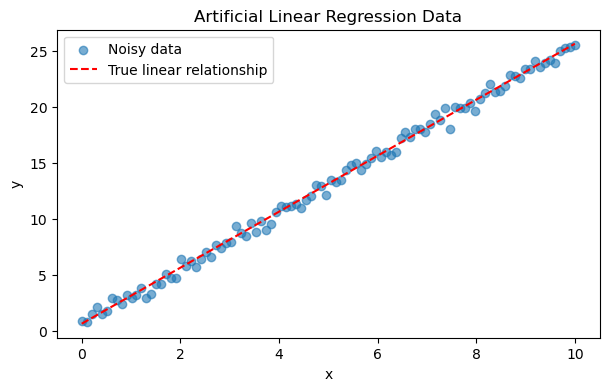

In [2]:
# Step 1: Generate Artificial Data
# We will create a simple linear regression dataset
np.random.seed(42)  # For reproducibility
x = np.linspace(0, 10, 100)  # 100 data points from 0 to 10
true_slope = 2.5
true_intercept = 0.65
# Generate noise
noise = np.random.normal(scale=0.5, size=len(x))
# Generate y values based on the linear model y = mx + c + noise
y = true_slope * x + true_intercept + noise

# Plotting the generated data
plt.figure(figsize=(7, 4))
plt.scatter(x, y, alpha=0.6, label='Noisy data')
plt.plot(x, true_slope * x + true_intercept, 'r--', label='True linear relationship')
plt.title('Artificial Linear Regression Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [3]:
# Step 2: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as model:
    # Priors for the unknown model parameters
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=slope * x + intercept, sigma=0.5, observed=y)

    # Step 3: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgd = pm.SVGD(n_particles=100, jitter=0.1, model=model)

    # Step 4: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approx = svgd.fit(10000)

Output()

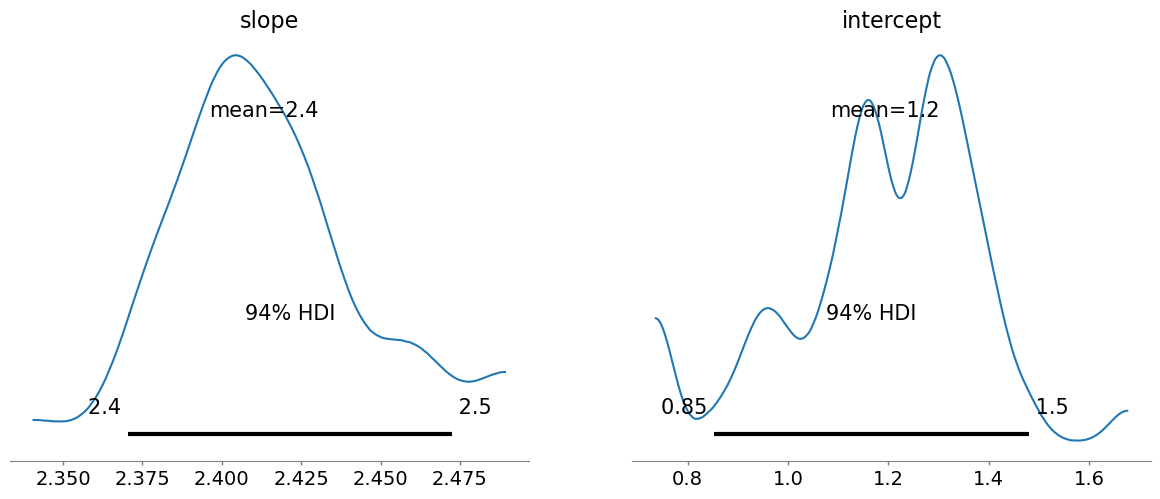

In [4]:
# Step 5: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
trace = approx.sample(100)

# Step 6: Visualize the Results
# plot the posterior distributions of the slope and the intercept
pm.plot_posterior(trace, var_names=['slope', 'intercept'])
plt.show()

This shows a KDE plot of the posterior distribution of the slope and the intercept. <span style="color:yellow">[DESCRIBE A BIT MORE IN DETAIL WHAT IT ACTUALLY MEANS]</span>.

In [5]:
# This just creates a summary of the slope and intercept variable that was learned (using the arviz package)
az.summary(trace, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.19,0.18,0.85,1.48,0.02,0.01,79.54,92.58,NaN
slope,2.41,0.03,2.37,2.47,0.00,0.00,74.92,89.63,NaN


To check the results from above, we calculate the mean and variance (standard deviation) manually.

The result is the same as with the az.summary() statistics.

In [6]:
# Extracting data for 'slope' and 'intercept'
slope_samples = trace.posterior["slope"].values
intercept_samples = trace.posterior["intercept"].values

# Calculate means and variances
slope_mean = np.mean(slope_samples)
intercept_mean = np.mean(intercept_samples)
slope_variance = np.var(slope_samples)
intercept_variance = np.var(intercept_samples)

print("Posterior Mean of Slope:", slope_mean)
print("Posterior Variance of Slope:", slope_variance)
print("Posterior Mean of Intercept:", intercept_mean)
print("Posterior Variance of Intercept:", intercept_variance)

# Calculate the standard deviation from the variance
slope_std_dev = np.sqrt(slope_variance)
intercept_std_dev = np.sqrt(intercept_variance)

print("Standard Deviation of Slope:", slope_std_dev)
print("Standard Deviation of Intercept:", intercept_std_dev)

Posterior Mean of Slope: 2.4132102339895707
Posterior Variance of Slope: 0.0008012937338748425
Posterior Mean of Intercept: 1.1941258722482593
Posterior Variance of Intercept: 0.031074585237423662
Standard Deviation of Slope: 0.0283071322085944
Standard Deviation of Intercept: 0.1762798492097825


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

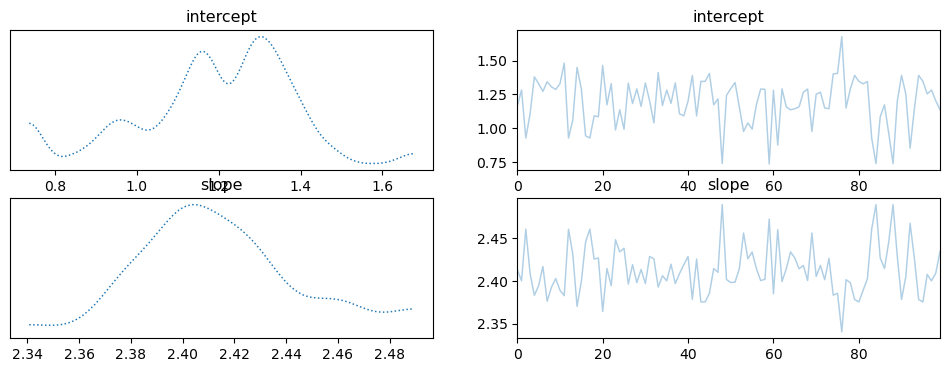

In [7]:
# The arviz package offers another way to plot both slope and intercept
az.plot_trace(trace, combined=True)

On the right side, we can see which slope and intercept has been samples at which point in time (in which order).

### Artificial Data - Langevin

<span style="color:yellow">@Pablo, maybe add some more comment and explainations in this section in the end</span>

#### Simulated Data

In [8]:
rng = default_rng()

# Set random seed for reproducibility
#np.random.seed(0)

# simulation of data points

d = 10 #number of variables
N = 1000 #number of observations

sigma_theta = 2
theta_star =  np.sqrt(sigma_theta) * np.random.randn(d)


# Generate data
X = np.random.randn(d, N)
logit = np.exp(np.dot(theta_star, X)) / (1 + np.exp(np.dot(theta_star, X)))
Y = np.random.binomial(1, logit)

# Define the proportion of data to be used for testing
test_size = 0.2

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y, test_size=test_size, random_state=42)

# Transpose X_train and X_test back to their original shapes
X_train = X_train.T
X_test = X_test.T

X, Y = X_train, Y_train

#### Langevin Algorithm
#TODO for Pablo: 
- Find more beautiful plots of the histograms
- apply langevin to the breastcancer dataset
- implement SVGD


In [9]:
#Function to compute the gradient of the potential
def grad_potential(theta: np.ndarray,
                   sigma_theta: int,
                   X: np.ndarray,
                   Y: np.ndarray) -> np.ndarray:
    '''
    theta: d by 1 vector: parameter of the Bayesian logistic regression model
    X: d by N matrix: each column is X_n
    Y: N by 1 vector: each entry is Y_n
    '''
    return - np.einsum('i,ji->j', Y - scipy.special.expit(np.dot(theta, X)), X) + theta/sigma_theta

# Init

# to induce sparsity change decomment these lines
alpha1 = np.arange(11)[11:0:-1]
alpha1 = np.repeat(alpha1, 10)
#alpha2 = 0.1

np.zeros(100)
alpha2 = 0.5

#ULA

def ula(gamma, lam, alpha1, alpha2, X, Y, theta_star, sigma_theta, seed, d=100, K=1000, print_freq=100):
    np.random.seed(seed)
    theta0 = np.random.normal(0, 1, d)
    theta = []
    error = []

    for i in range(K):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = theta0 - gamma * grad_potential(theta0, sigma_theta, X, Y) + np.sqrt(2*gamma) * xi
        theta.append(theta_new)
        error.append(np.linalg.norm(theta_new - theta_star))
        if i == 0 or i % print_freq == print_freq - 1:
            print('iteration {}: error = {}'.format(i + 1, np.linalg.norm(theta_new - theta_star)))
        theta0 = theta_new

    return theta, error

# ULA Main Loop

S = 1
Theta1 = []
Error1 = []

K = 30000
gamma = 5e-4
gamma = 1e-4
#gamma = 5e-5
#gamma = 1e-5

for j in range(S):
    print('j =', j)
    theta1, error1 = ula(gamma, 1e-2, alpha1, alpha2, X, Y, theta_star, sigma_theta, j, d, K)
    Theta1.append(theta1)
    Error1.append(error1)

theta1 = np.mean(np.array(Theta1), axis=0)
error1 = np.array([np.linalg.norm(theta1[i] - theta_star) for i in range(K)])

#plt.figure(0, figsize=(8,6))
#plt.plot(np.arange(K), error1)

j = 0
iteration 1: error = 4.361827915762799
iteration 100: error = 2.110141119569329
iteration 200: error = 1.033102885896278
iteration 300: error = 0.7446824339413715
iteration 400: error = 0.44655766029109817
iteration 500: error = 0.5019621774776478
iteration 600: error = 0.4332003141324197
iteration 700: error = 0.46562116249531277
iteration 800: error = 0.4593938944717654
iteration 900: error = 0.6083480654821619
iteration 1000: error = 0.6823018513064879
iteration 1100: error = 0.5260669873571866
iteration 1200: error = 0.6248944631947355
iteration 1300: error = 0.6507995651523959
iteration 1400: error = 0.41599455212057623
iteration 1500: error = 0.6378953072034543
iteration 1600: error = 0.6558374986239803
iteration 1700: error = 0.41284391253371366
iteration 1800: error = 0.6544540898746403
iteration 1900: error = 0.5153552881276621
iteration 2000: error = 0.4777382362951915
iteration 2100: error = 0.6087845023613144
iteration 2200: error = 0.5369487127084335
iteration 2300: 

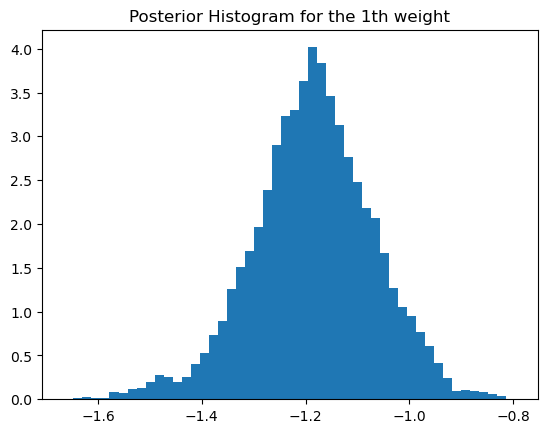

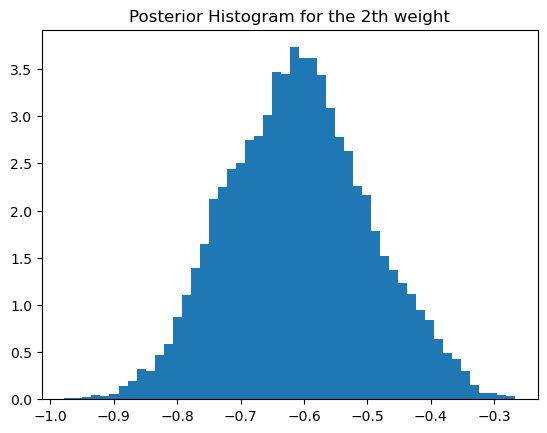

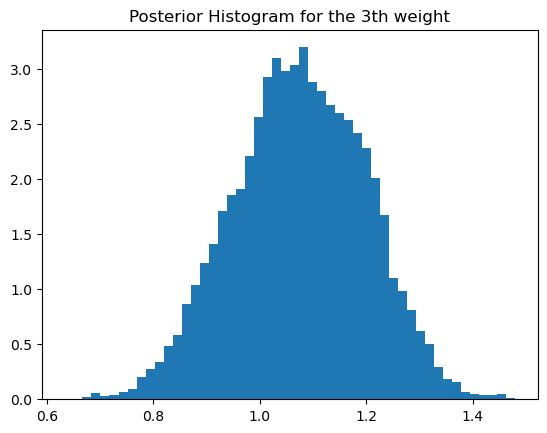

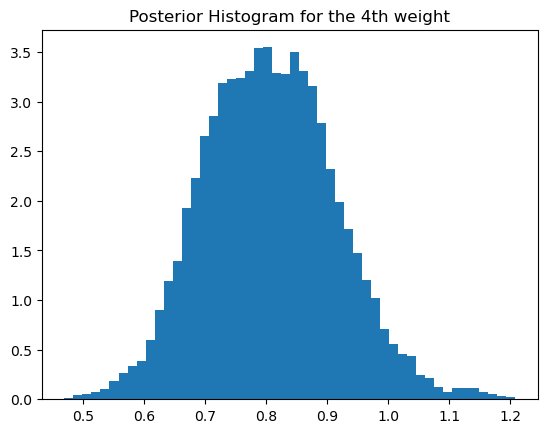

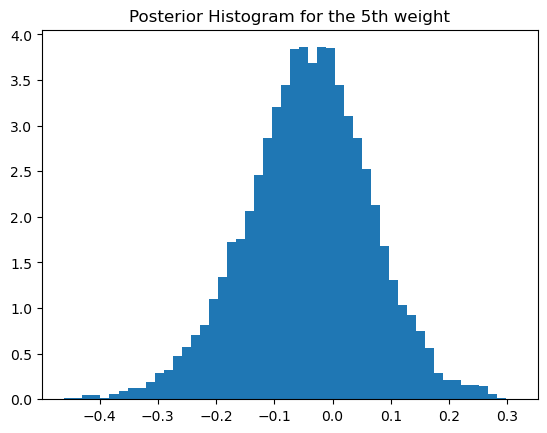

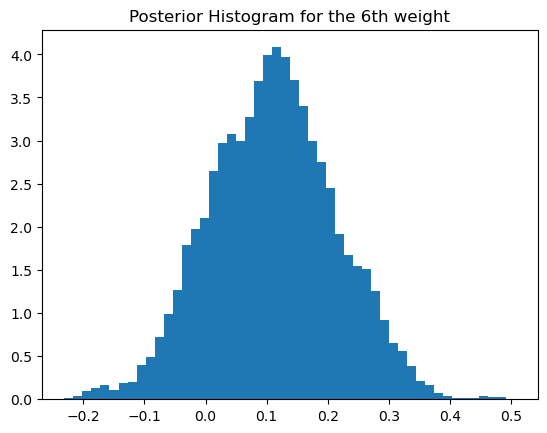

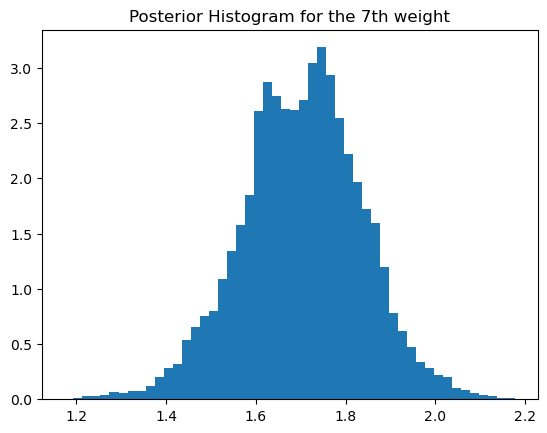

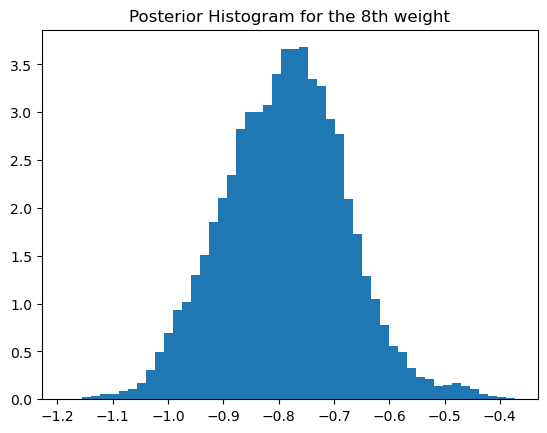

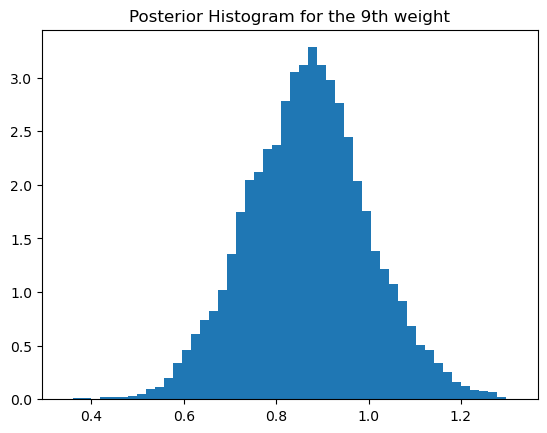

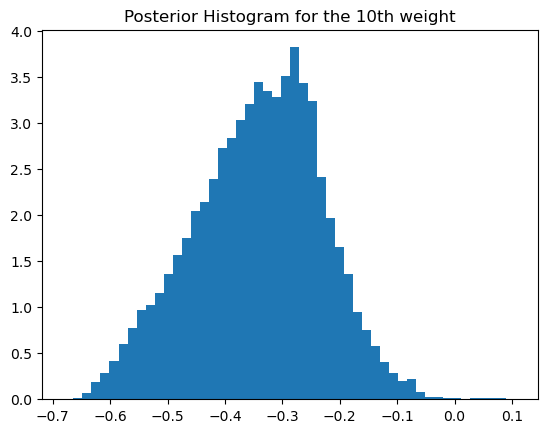

In [10]:
for i in range(d):
  plt.figure()
  plt.title(f"Posterior Histogram for the {i+1}th weight")
  plt.hist(theta1[int(K/10):K, i],density=True, bins=50, label="Langevin")

In [11]:
def predict_posterior_samples(theta_samples, X_test):
    """
    Predict labels for test data using samples from the posterior distribution.

    Parameters:
        theta_samples (ndarray): Samples from the posterior distribution of parameters.
        X_test (ndarray): Test data features.

    Returns:
        ndarray: Predicted labels for test data.
    """
    num_samples = len(theta_samples)
    num_test_points = X_test.shape[1]
    predictions = np.zeros(num_test_points)
    logit = np.zeros(num_test_points) #new

    for theta in theta_samples:
        #logit = np.exp(np.dot(theta, X_test)) / (1 + np.exp(np.dot(theta, X_test)))
        #sample_predictions = (logit > 0.5).astype(int)
        #predictions += sample_predictions
        logit += np.exp(np.dot(theta, X_test)) / (1 + np.exp(np.dot(theta, X_test))) #new

    #average_predictions = predictions / num_samples
    average_predictions = (logit > 0.5*num_samples).astype(int) #new


    return np.round(average_predictions)


# Assuming you have your test data in X_test and true labels in Y_test
# Predict labels using posterior samples
predicted_labels = predict_posterior_samples(theta1, X_test)

# Compute accuracy
accuracy = np.mean(predicted_labels == Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.815


#### SVGD

In [12]:
# Step 1: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as simModel:
    # Priors for the unknown model parameters
    weights = pm.MvNormal('Weights', mu=0, cov = np.eye(X.shape[0]), shape=(X.shape[0],))

    # Calculate probabilities using the logistic function
    logits = pm.math.dot(weights, X)
    probability = pm.Deterministic('probability', pm.math.sigmoid(logits))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=probability, observed=Y)

    # Step 2: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgdSim = pm.SVGD(n_particles=100, jitter=0.1, model=simModel)

    # Step 3: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approxSim = svgdSim.fit(10000)

Output()

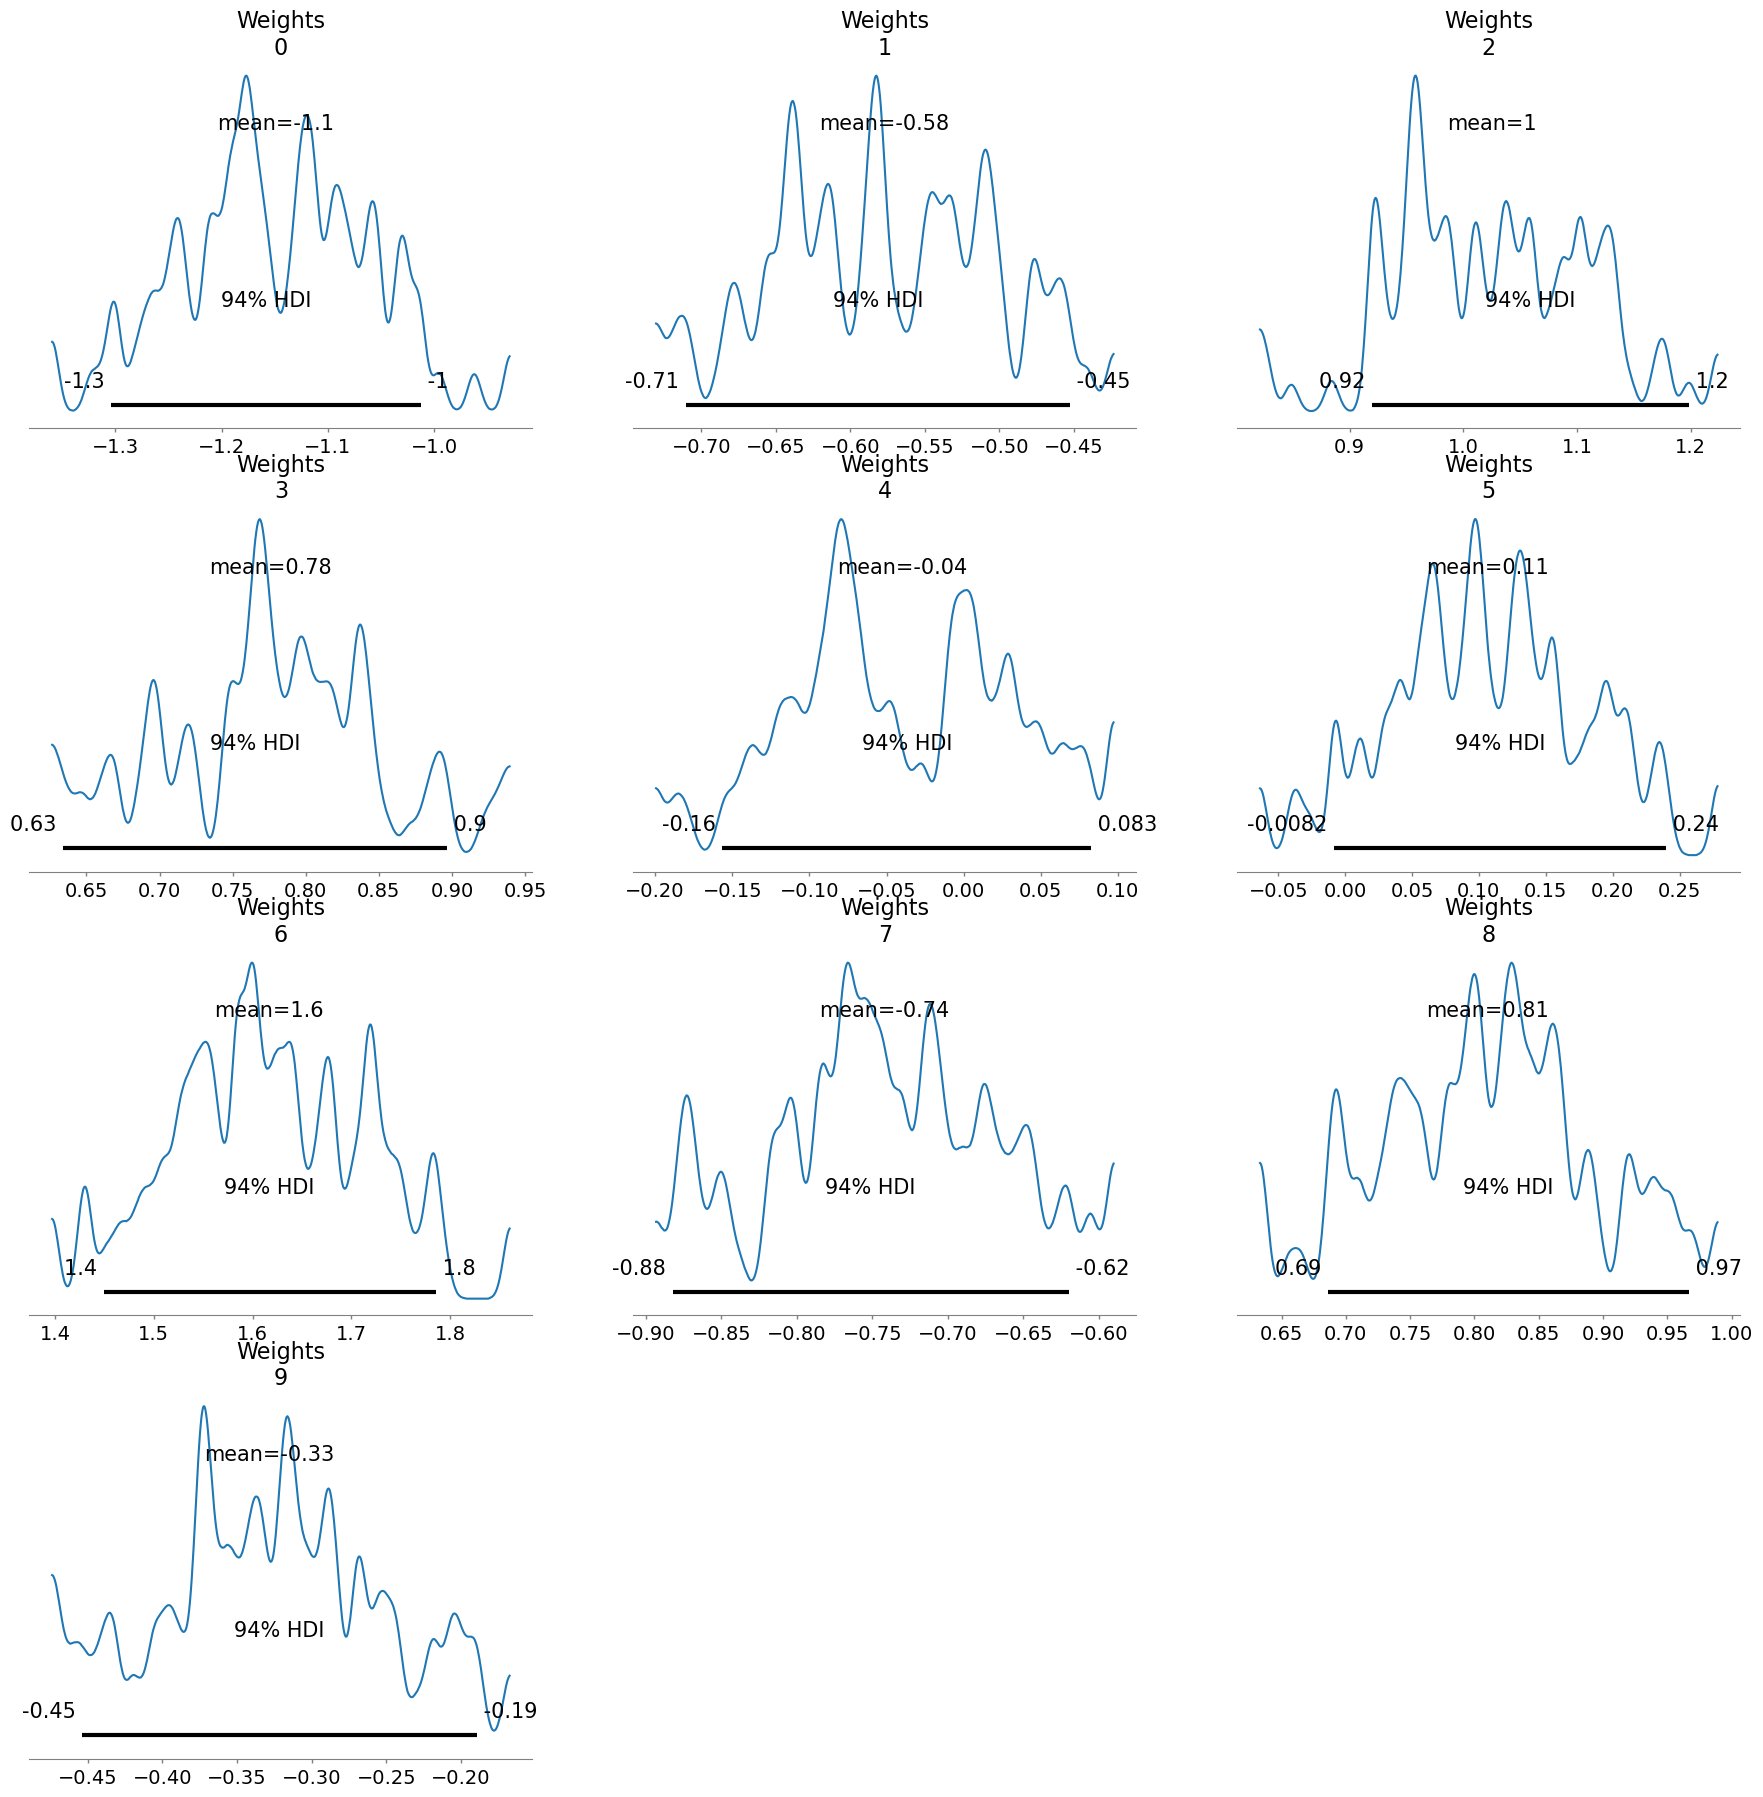

In [13]:
# Step 4: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
traceSim = approxSim.sample(10000)

# Step 5: Visualize the Results
pm.plot_posterior(traceSim, var_names=['Weights'])
plt.show()

# Application to real data: the Wisconsin Breast Cancer (Diagnostic) Dataset

### Introduction to the dataset

We decided on the utilization of the Wisconsin Breast Cancer (Diagnostic) Dataset. The advantage is that it is directly available via sklearn. Moreover, it does not contain any missing values. The disadvantage is maybe that with 30 there are a lot of features. However, this shouldn't be a real problem.

Additional information on the dataset can be found under this link: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Here some basic descriptives of the dataset:

**Features:** 30 (real-valued inputs)

**Instances:** 569

**Problem:** Predict whether the cancer is benign or malignant based on cell nucleus characteristics.

**Benefits:** Offers a binary classification problem with more features than the Pima Indians dataset, allowing for a deeper exploration of feature relationships using logistic regression.

In the following cell, the dataset is simply loaded and the head (and below the info) is displayed for a quick overview:

In [14]:
# Load the dataset
data = load_breast_cancer()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the DataFrame
df['target'] = data.target

# Display the first few rows of the DataFrame, only 3 as the output would be a bit long otherwise
print(df.head(3))

# Show the shape of the DataFrame to verify
print("Data shape:", df.shape)

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33            184.6      2019.0   
1                 0.05667  ...          23.41            158.8      1956.0   
2                 0.05999  ...          25.53            152.5      1709.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

We did not normalize the data in the beginning but encountered an error when trying to fit the model down below. Normalizing all 30 features (so that they are between 0 and 1 helped) to overcome this:

### Short Preprocessing (Normalization)

In [16]:
# normalizing the features using the MinMaxScaler() from sklearn
scaler = MinMaxScaler()
feature_columns = df.columns[df.columns != 'target']
X = df[feature_columns].values
X_scaled = scaler.fit_transform(X)
df[feature_columns] = X_scaled
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0


## Real Data - SVGD

Now, we take the code from above (SVGD and linear data) and adapt it to the real data. That includes that we don't have only one slope any more but 30 weights for 30 features instead. The target variable is Bernoulli distributed.

In [17]:
X = df.drop('target', axis=1).values  # Features
y = df['target'].values  # Target variable

# Step 1: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as cancerModel:
    # Priors for the unknown model parameters
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    weights = pm.MvNormal('Weights', mu=0, cov = np.eye(30), shape=(X.shape[1],))

    # Calculate probabilities using the logistic function
    logits = intercept + pm.math.dot(X, weights)
    probability = pm.Deterministic('probability', pm.math.sigmoid(logits))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', p=probability, observed=y)

    # Step 2: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgdCancer = pm.SVGD(n_particles=100, jitter=0.1, model=cancerModel)

    # Step 3: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approxCancer = svgdCancer.fit(10000)

Output()

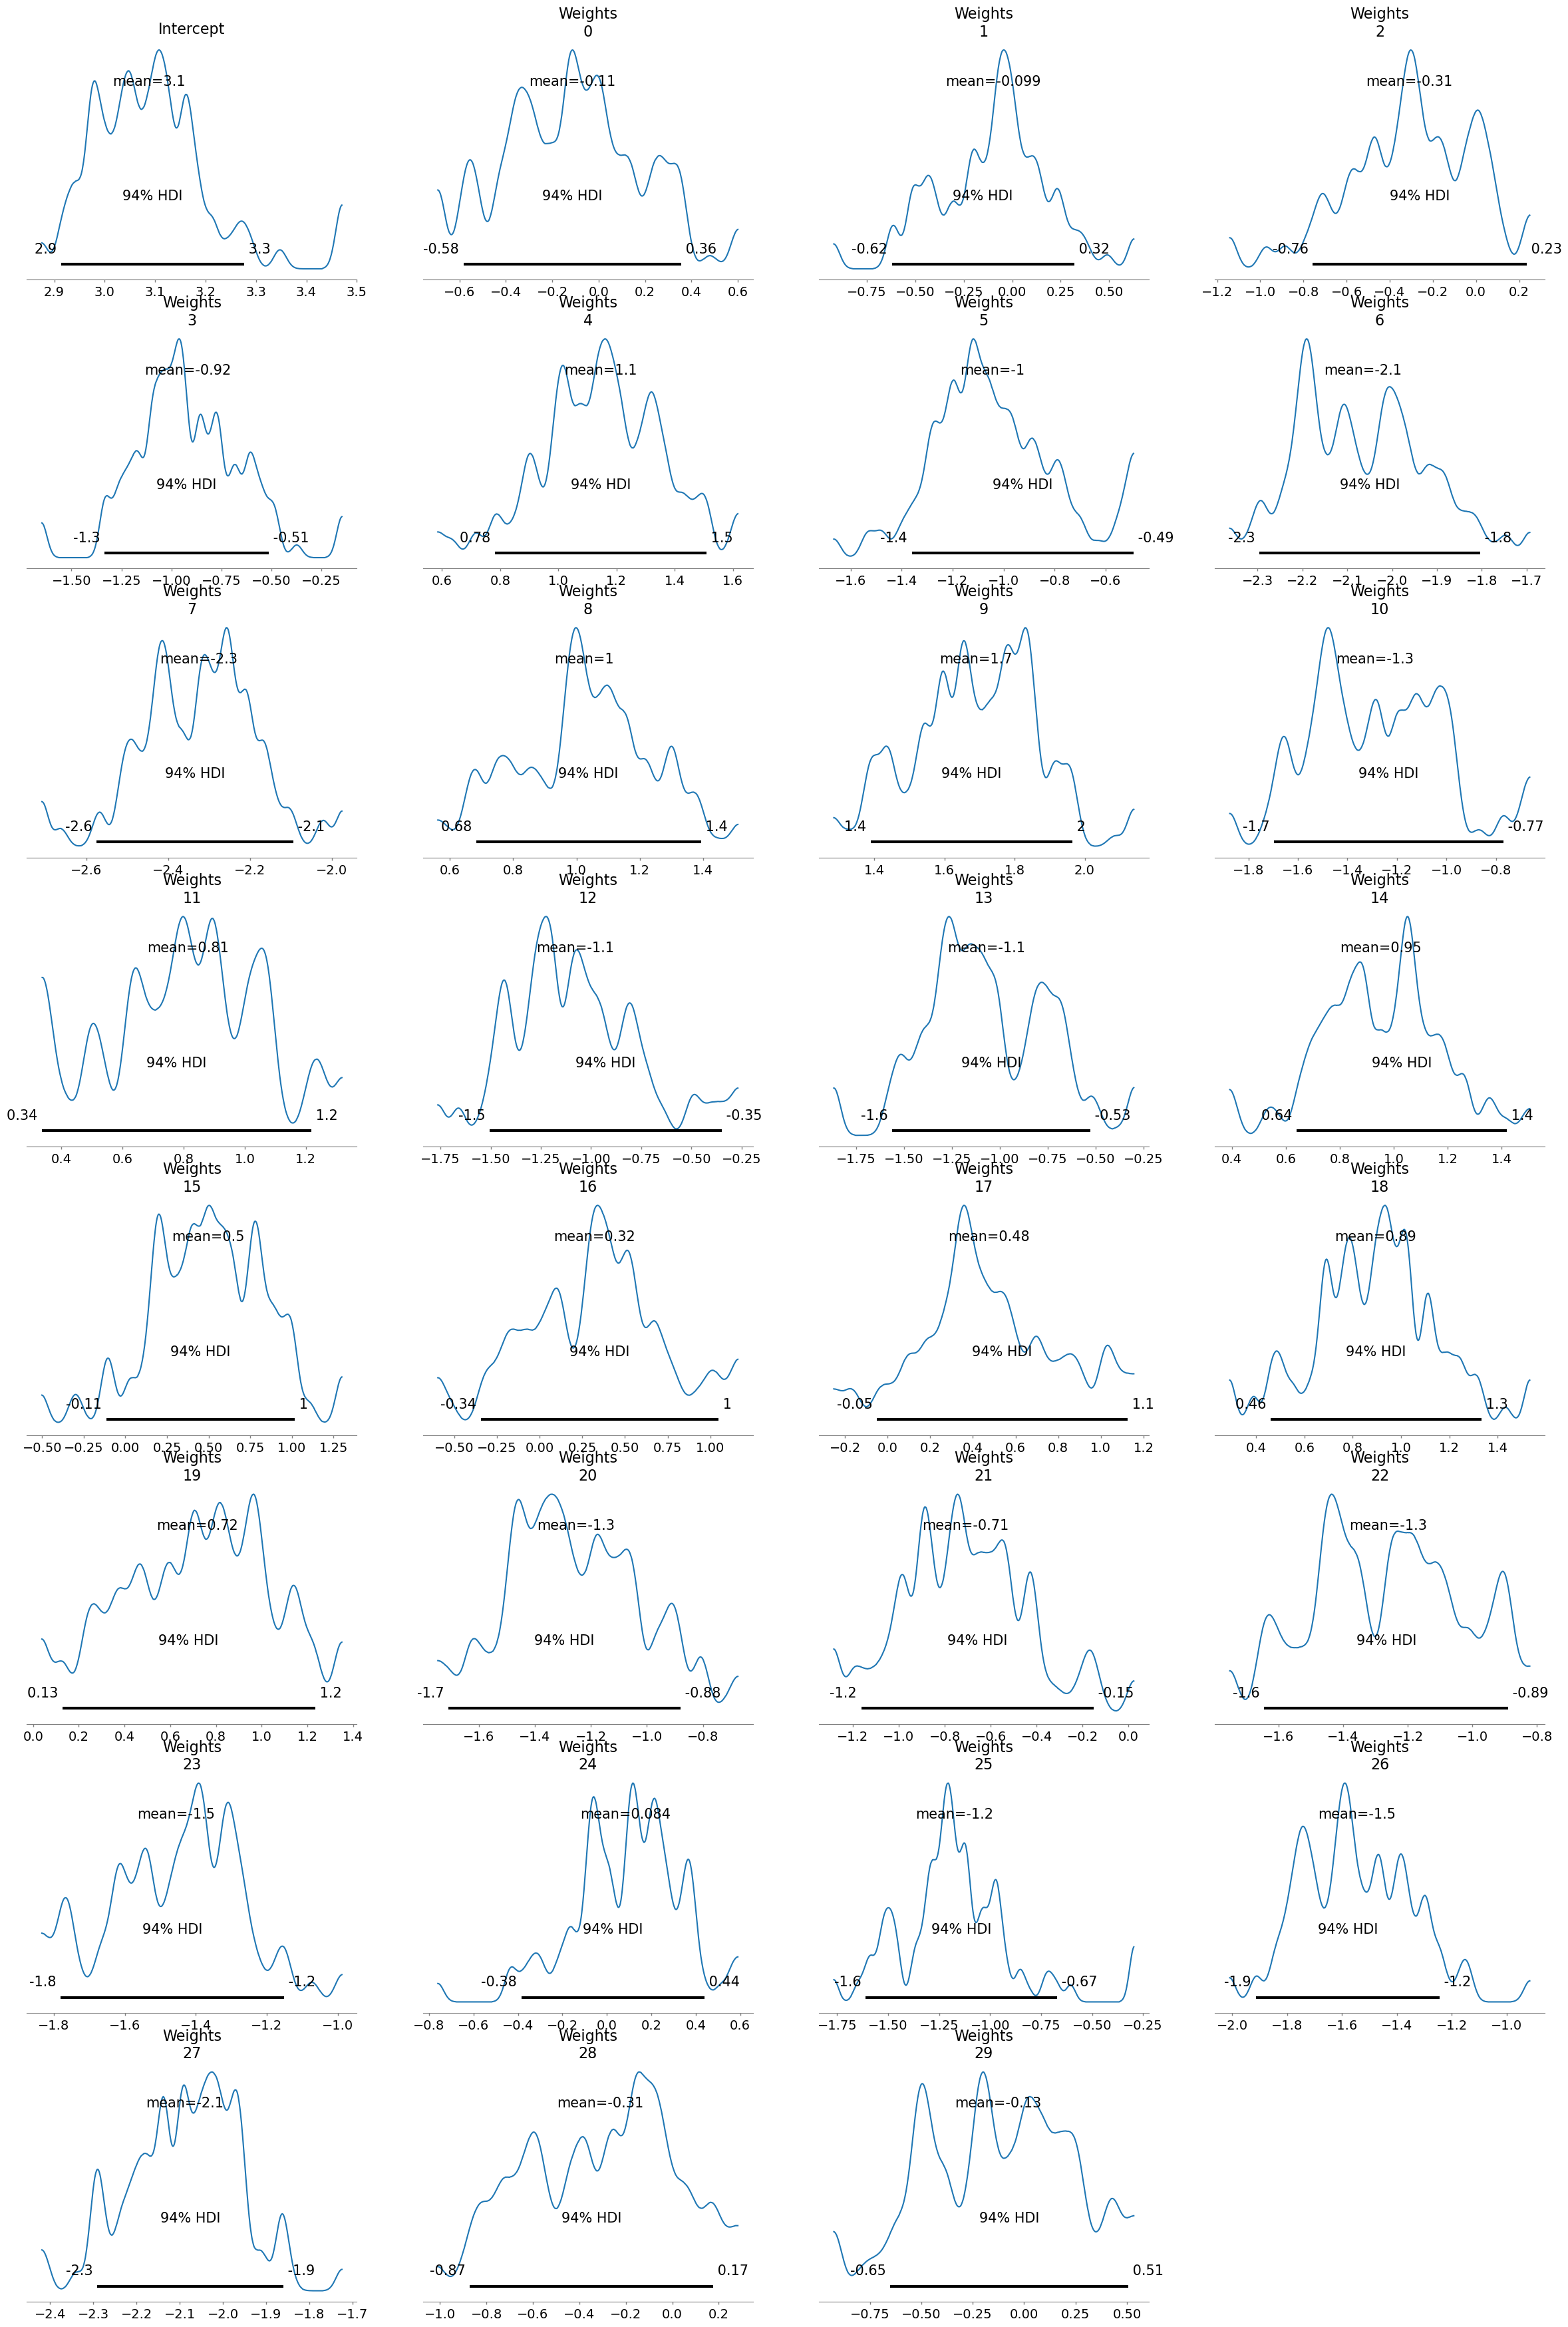

In [18]:
# Step 4: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
traceCancer = approxCancer.sample(1000)

# Step 5: Visualize the Results
pm.plot_posterior(traceCancer, var_names=['Intercept', 'Weights'])
plt.show()

### Analysis and Experiments of the SVGD with real data

At this point in time, the model from above should work and we can run some experiments that help to understand the results better.
First, we simply create a summary table showing for example mean and standard devitation for the different weights.


In [19]:
pm.summary(traceCancer, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.09,0.11,2.91,3.28,0.00,0.00,1094.51,989.88,NaN
Weights[0],-0.11,0.28,-0.58,0.36,0.01,0.01,996.15,941.56,NaN
Weights[1],-0.10,0.28,-0.62,0.32,0.01,0.01,1050.40,852.64,NaN
Weights[2],-0.31,0.28,-0.76,0.23,0.01,0.01,998.53,930.22,NaN
Weights[3],-0.92,0.25,-1.34,-0.51,0.01,0.01,948.20,990.06,NaN
...,...,...,...,...,...,...,...,...,...
probability[564],0.01,0.00,0.01,0.01,0.00,0.00,982.91,978.75,NaN
probability[565],0.06,0.01,0.05,0.07,0.00,0.00,970.36,973.63,NaN
probability[566],0.25,0.02,0.22,0.27,0.00,0.00,887.81,966.27,NaN
probability[567],0.00,0.00,0.00,0.00,0.00,0.00,892.16,830.84,NaN


PyMC also offers an option to create a graph of the model that has been learned. Have a look on the following link for more information:
https://www.pymc.io/projects/docs/en/latest/api/model/generated/pymc.model_graph.model_to_graphviz.html#pymc.model_graph.model_to_graphviz

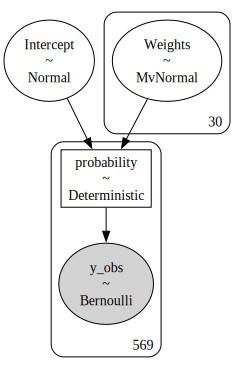

In [20]:
model_to_graphviz(cancerModel)

#### Predictive Checks

We now generate posterior predictive checks to see how well the model predicts new data. We're sampling from the posterior predictive distribution and compare these predictions to actual outcomes from the dataset.

Information can for example be found under the following link: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html

After conducting the Bayesian inference and obtaining the posterior distribution of the parameters, we can generate new data sets from these parameters:

In [21]:
with cancerModel:
    # Sample from the posterior predictive distribution
    posterior_predictive = pm.sample_posterior_predictive(traceCancer, var_names=['y_obs'])

Sampling: [y_obs]


Output()

In [22]:
print(posterior_predictive.keys())

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


<Axes: xlabel='target', ylabel='Count'>

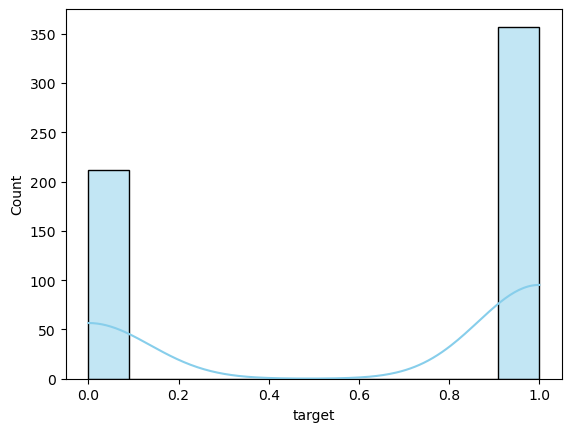

In [23]:
# Plot observed data
sns.histplot(data=df['target'], color="skyblue", label="Observed Data", kde=True)

<xarray.DataArray 'y_obs' (chain: 1, draw: 1000, y_obs_dim_2: 569)> Size: 5MB
array([[[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]])
Coordinates:
  * chain        (chain) int64 8B 0
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * y_obs_dim_2  (y_obs_dim_2) int64 5kB 0 1 2 3 4 5 ... 563 564 565 566 567 568


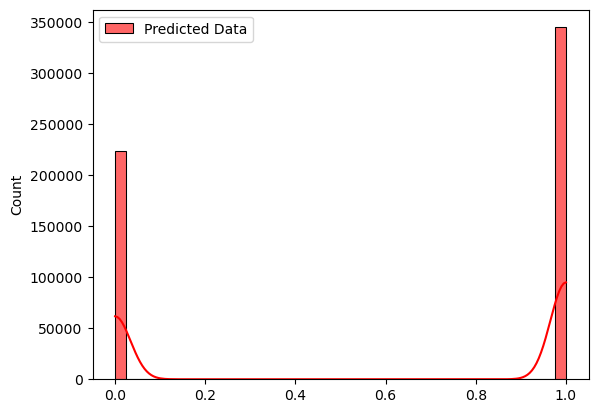

In [24]:
# Plot predicted data
posterior_predictive = posterior_predictive.posterior_predictive
predicted_data = posterior_predictive['y_obs']

# Check what's inside predicted_data
print(predicted_data)

# data had a 3D format with 1 markov chain, while sns.histplot() required 2D
flattened_data = predicted_data.values.flatten()

sns.histplot(flattened_data, color="red", label="Predicted Data", kde=True, alpha=0.6)

plt.legend()
plt.show()

At this point we have plotted both the predicted and the actual observed data in separate diagrams. For better comparison, we plot both of them in one diagram using the following cell.

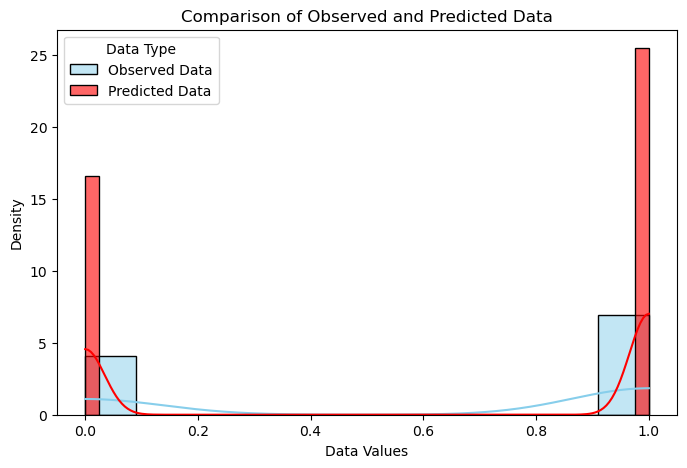

In [25]:
# Assuming df['target'] is your observed data
observed_data = df['target']

# Assume you already have your flattened_data from the posterior predictive
# Make sure to flatten your predicted data as you have done
flattened_data = predicted_data.values.flatten()

# Plot setup
plt.figure(figsize=(8, 5))

# Plotting observed data
sns.histplot(observed_data, color="skyblue", label="Observed Data", kde=True, stat="density")

# Plotting predicted data
sns.histplot(flattened_data, color="red", label="Predicted Data", kde=True, stat="density", alpha=0.6)

# Adding legend and titles
plt.legend(title="Data Type")
plt.title("Comparison of Observed and Predicted Data")
plt.xlabel("Data Values")
plt.ylabel("Density")
plt.show()

The observed and predicted mean is very similar, showing once more that the sampled data looks quite similar to the actual data from the dataset.

In [26]:
print("Observed Mean:", observed_data.mean())
print("Predicted Mean:", predicted_data.mean().item())

Observed Mean: 0.6274165202108963
Predicted Mean: 0.606115992970123


## Real Data - Langevin

<span style="color:yellow">@Pablo, here we should add the code that uses langevin on the real data</span>